In [1]:
import os
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
from tensorflow.keras.utils import to_categorical

from scipy.stats import entropy
from scipy import signal
from scipy.signal import butter, filtfilt
from scipy.stats import skew, kurtosis
from scipy.special import rel_entr

from skimage import io,transform
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

2024-01-28 14:27:20.586848: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-28 14:27:20.586884: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-28 14:27:20.588270: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-28 14:27:20.597019: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-28 14:27:21.812193: W tensorflow/compiler/tf2

In [2]:
def read_data(data_folder, num_files=None):
    """
    Read EEG and spectrogram data from Parquet files in the specified data folder.

    Parameters:
    - data_folder (str): Path to the main data folder containing 'train' and 'test' subfolders.
    - num_files (int or None): Number of files to read from each subfolder. If None, all files will be read.

    Returns:
    - train (List[Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]]): List of tuples containing train EEG data, train spectrogram data, and labels.
    - test (List[Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]]): List of tuples containing test EEG data, test spectrogram data, and labels.
    """
    train_eeg_folder = os.path.join(data_folder, 'train_eegs')
    test_eeg_folder = os.path.join(data_folder, 'test_eegs')
    train_spectrograms_folder = os.path.join(data_folder, 'train_spectrograms')
    test_spectrograms_folder = os.path.join(data_folder, 'test_spectrograms')

    def read_parquet_folder(folder_path, n_files=None):
        dataframes = []
        files_to_read = os.listdir(folder_path)[:n_files] if n_files else os.listdir(folder_path)
        for file in files_to_read:
            if file.endswith('.parquet'):
                file_path = os.path.join(folder_path, file)
                dataframe = pq.read_table(file_path).to_pandas()
                dataframes.append(dataframe)
        print(f"Read {len(dataframes)} files from {folder_path}.")
        return dataframes

    # Read EEG data
    train_eeg = read_parquet_folder(train_eeg_folder, num_files)
    test_eeg = read_parquet_folder(test_eeg_folder, num_files)

    # Read spectrogram data
    train_spectrograms = read_parquet_folder(train_spectrograms_folder, num_files)
    test_spectrograms = read_parquet_folder(test_spectrograms_folder, num_files)

    # Read label information from CSV files
    train_labels_ = pd.read_csv('train.csv')  # assuming 'train.csv' is in the current directory
    test_labels_ = pd.read_csv('test.csv')  # assuming 'test.csv' is in the current directory

    # Combine data, spectrograms, and labels into tuples
    train_data = [(eeg, spec, labels_row) for eeg, spec, labels_row in zip(train_eeg, train_spectrograms, train_labels_.itertuples(index=False))]
    test_data = [(eeg, spec, labels_row) for eeg, spec, labels_row in zip(test_eeg, test_spectrograms, test_labels_.itertuples(index=False))]

    return train_data, test_data

In [3]:
def single_vis(f, visualization_type):
    """
    Visualize single EEG channels or Spectrogram from the provided DataFrame.

    Parameters:
    - f (pd.DataFrame): The DataFrame containing the data to be visualized.
    - visualization_type (str): Specify the type of visualization: 'eeg' for EEG channels or 'spectrogram' for Spectrogram.

    Raises:
    - ValueError: If an invalid `visualization_type` is provided.

    Returns:
    None
    """
    
    if visualization_type == 'eeg':
        channels_to_exclude = []
        title = 'EEG Channels Visualization'
        
        eeg_channels = [column for column in f.columns if column not in channels_to_exclude]
        plt.figure(figsize=(40, 10))
        
        # Calculate the offset for each channel based on the maximum amplitude
        max_amplitude = f[eeg_channels].max().max()
        channel_offset = max_amplitude * 1.2  # Adjust the multiplier as needed
        
        for i, column in enumerate(eeg_channels):
            y_values = f[column] + i * channel_offset
            plt.plot(f.index, y_values, label=column)

        plt.title(title)
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.show()
        
    elif visualization_type == 'spectrogram':
        channels_to_exclude = ['time']
        title = 'Spectrogram Visualization'
        
        spectrogram_channels = [column for column in f.columns if column not in channels_to_exclude]
        plt.figure(figsize=(40, 10))
        
        combined_spectrogram = np.zeros((len(f), len(spectrogram_channels)))
        for i, column in enumerate(spectrogram_channels):
            combined_spectrogram[:, i] = f[column].values
        
        plt.imshow(combined_spectrogram.T, aspect='auto', cmap='viridis', interpolation='nearest')
        plt.title(title)
        plt.xlabel('Sample')
        plt.ylabel('Channel')
        plt.show()
        
    else:
        raise ValueError("Invalid visualization type. Use 'eeg' or 'spectrogram'.")


In [4]:
train,test = read_data('data',1000)

Read 1000 files from data/train_eegs.
Read 1 files from data/test_eegs.
Read 1000 files from data/train_spectrograms.
Read 1 files from data/test_spectrograms.


In [5]:
train_features = [(eeg, spec) for eeg, spec, _ in train]
train_labels = [labels_row for _, _, labels_row in train]
X_train, X_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=0.2, random_state=42,shuffle=True)

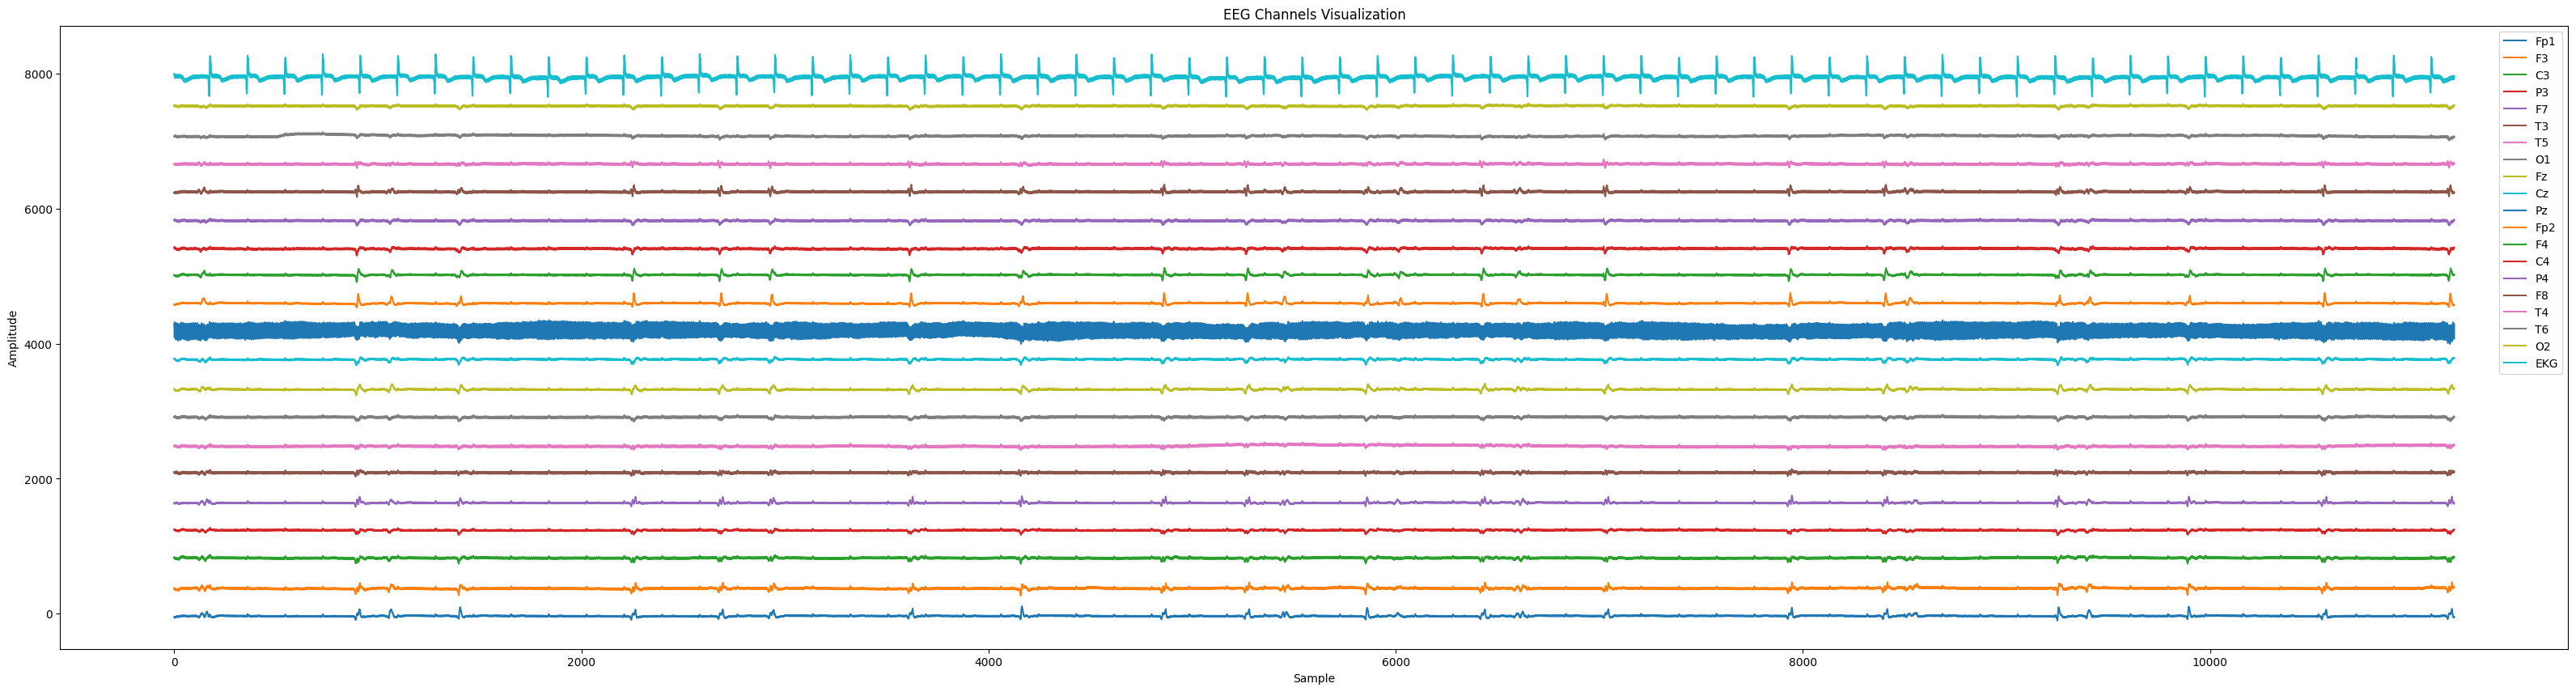

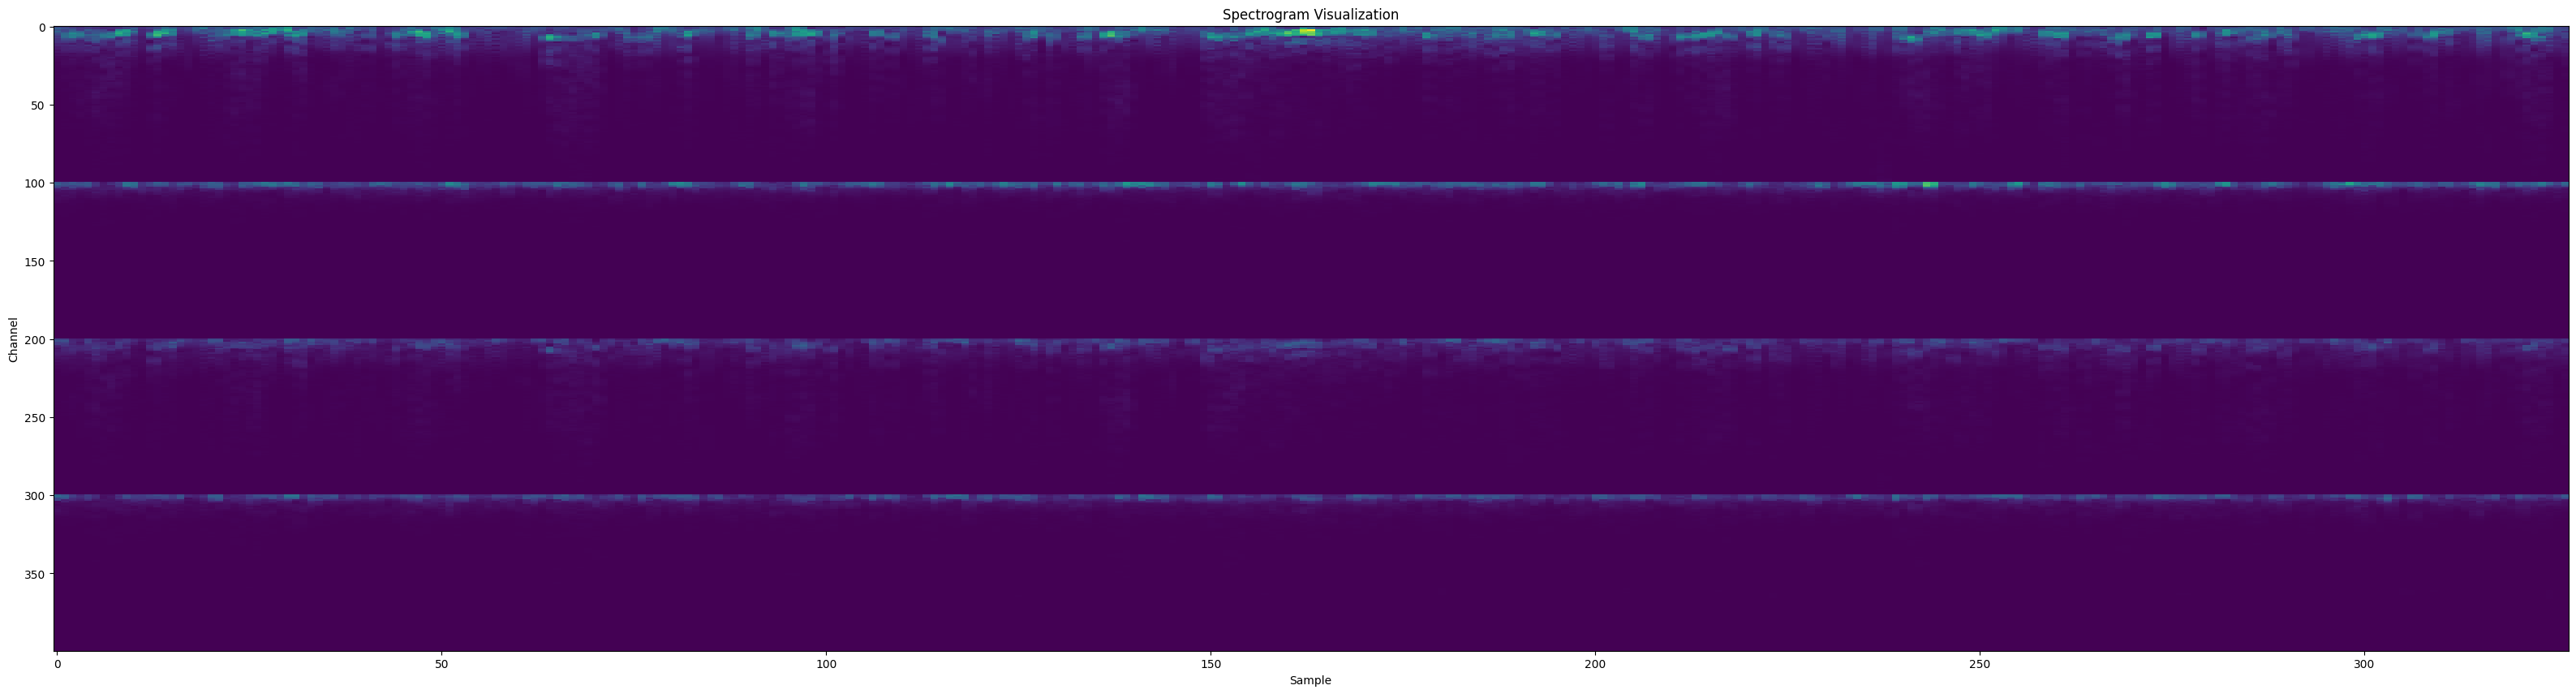

In [6]:
single_vis(X_train[1][0], 'eeg')
single_vis(X_train[1][1], 'spectrogram')